<a href="https://colab.research.google.com/github/AniketVelhankar/Covid-19-classification/blob/master/Covid_19_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The following notebook demonstrates classification of covid-19 chest radiographs from bacterial pneumonia, viral pneumonia and normal cases.
### The dataset used is [COVID-19 Detection X-Ray Dataset](https://www.kaggle.com/darshan1504/covid19-detection-xray-dataset) available on Kaggle.

### Setup kaggle api to download dataset from kaggle
1.   Create account on kaggle / login to kaggle account.
2.   Go to **your account**, **api** section and create a api token. 
This will download kaggle.json file to local machine.
3.   Upload kaggle.json here.
4. Install kaggle
4. Copy api command from kaggle dataset and execute command


In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!ls ~/.kaggle

kaggle.json


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
! pip install -q kaggle

In [0]:
!kaggle datasets download -d darshan1504/covid19-detection-xray-dataset

 97% 181M/186M [00:05<00:00, 32.8MB/s]
100% 186M/186M [00:05<00:00, 38.5MB/s]


In [0]:
! mkdir covid19-detection-xray-dataset

In [0]:
cd /content/covid19-detection-xray-dataset/

/content/covid19-detection-xray-dataset


In [0]:
!unzip /content/covid19-detection-xray-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: NonAugmentedTrain/BacterialPneumonia/165.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/166.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/167.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/168.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/169.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/17.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/170.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/171.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/172.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/173.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/174.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/175.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/176.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/177.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/178.jpeg  
  inflating: NonAugmentedTrain/Bact

### Import required libraries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import time
import os
import copy

### Preprocessing

In [0]:
data_transforms = {
    'NonAugmentedTrain': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'ValData': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/covid19-detection-xray-dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['NonAugmentedTrain', 'ValData']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['NonAugmentedTrain', 'ValData']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['NonAugmentedTrain', 'ValData']}
class_names = image_datasets['NonAugmentedTrain'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
device

device(type='cuda', index=0)

In [0]:
dataset_sizes

{'NonAugmentedTrain': 2002, 'ValData': 988}

In [0]:
class_names

['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia']

### Check a batch of images

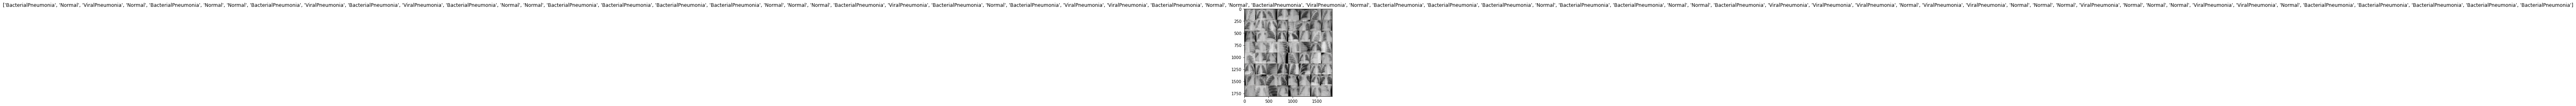

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['NonAugmentedTrain']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Train script

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['NonAugmentedTrain', 'ValData']:
            if phase == 'NonAugmentedTrain':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'NonAugmentedTrain'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'NonAugmentedTrain':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'NonAugmentedTrain':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'ValData' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['ValData']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Resnet18

In [0]:
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs_rsn18 = model_resnet18.fc.in_features

model_resnet18.fc = nn.Linear(num_ftrs_rsn18, len(class_names))

model_resnet18 = model_resnet18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet18.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
model_resnet18 = train_model(model_resnet18, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
NonAugmentedTrain Loss: 0.7969 Acc: 0.6733
ValData Loss: 2.5082 Acc: 0.7126

Epoch 1/9
----------
NonAugmentedTrain Loss: 0.5919 Acc: 0.7542
ValData Loss: 0.7197 Acc: 0.6619

Epoch 2/9
----------
NonAugmentedTrain Loss: 0.5647 Acc: 0.7592
ValData Loss: 0.6912 Acc: 0.6781

Epoch 3/9
----------
NonAugmentedTrain Loss: 0.5328 Acc: 0.7642
ValData Loss: 0.7737 Acc: 0.7460

Epoch 4/9
----------
NonAugmentedTrain Loss: 0.5118 Acc: 0.7772
ValData Loss: 0.6808 Acc: 0.7409

Epoch 5/9
----------
NonAugmentedTrain Loss: 0.5072 Acc: 0.7877
ValData Loss: 0.9019 Acc: 0.7247

Epoch 6/9
----------
NonAugmentedTrain Loss: 0.5049 Acc: 0.7842
ValData Loss: 0.9056 Acc: 0.5294

Epoch 7/9
----------
NonAugmentedTrain Loss: 0.4693 Acc: 0.8007
ValData Loss: 0.7134 Acc: 0.6943

Epoch 8/9
----------
NonAugmentedTrain Loss: 0.4174 Acc: 0.8267
ValData Loss: 0.6141 Acc: 0.7095

Epoch 9/9
----------
NonAugmentedTrain Loss: 0.3854 Acc: 0.8267
ValData Loss: 0.6067 Acc: 0.7176

Training complete in

### Save best resnet18 model for future purposes : Best val acc 74.59 %

In [0]:
# Save checkpoints in /content/covid19-detection-xray-dataset/
torch.save(model_resnet18.state_dict(), 'model_resnet18_10epochs.pth')

### Experimenting with Resnet50

In [0]:
model_resnet50 = models.resnet50(pretrained=True)
num_ftrs_rsn50 = model_resnet50.fc.in_features

model_resnet50.fc = nn.Linear(num_ftrs_rsn50, len(class_names))

model_resnet50 = model_resnet50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet50.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
model_resnet50 = train_model(model_resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
NonAugmentedTrain Loss: 0.7993 Acc: 0.6813
ValData Loss: 3.9225 Acc: 0.4545

Epoch 1/14
----------
NonAugmentedTrain Loss: 0.6588 Acc: 0.7288
ValData Loss: 0.7361 Acc: 0.7075

Epoch 2/14
----------
NonAugmentedTrain Loss: 0.6135 Acc: 0.7582
ValData Loss: 2.8941 Acc: 0.7136

Epoch 3/14
----------
NonAugmentedTrain Loss: 0.6254 Acc: 0.7433
ValData Loss: 0.6764 Acc: 0.7186

Epoch 4/14
----------
NonAugmentedTrain Loss: 0.5588 Acc: 0.7672
ValData Loss: 0.6454 Acc: 0.7014

Epoch 5/14
----------
NonAugmentedTrain Loss: 0.5510 Acc: 0.7757
ValData Loss: 0.8900 Acc: 0.5982

Epoch 6/14
----------
NonAugmentedTrain Loss: 0.5613 Acc: 0.7662
ValData Loss: 0.7030 Acc: 0.7126

Epoch 7/14
----------
NonAugmentedTrain Loss: 0.4900 Acc: 0.7827
ValData Loss: 0.6213 Acc: 0.6903

Epoch 8/14
----------
NonAugmentedTrain Loss: 0.4550 Acc: 0.8167
ValData Loss: 0.6268 Acc: 0.7126

Epoch 9/14
----------
NonAugmentedTrain Loss: 0.4461 Acc: 0.8092
ValData Loss: 0.6155 Acc: 0.7034

Epoch 10/1

### Save best resnet50 model for future purposes :  Best val acc 72.87 %


In [0]:
torch.save(model_resnet50.state_dict(), 'model_resnet50_15epochs.pth')

### Experimenting with Efficient-Net 

In [0]:
# Download efficient-net
! pip install efficientnet-pytorch 

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=2a30eaae806aca2175cccd0ff3c7a849d9d19baac3e0f5f97abb5ffd5c0cdd85
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [0]:
from efficientnet_pytorch import EfficientNet
model_efficientnetb0 = EfficientNet.from_pretrained('efficientnet-b0')

num_ftrs_efb0 = model_efficientnetb0._fc.in_features

model_efficientnetb0._fc = nn.Linear(num_ftrs_efb0, len(class_names))

model_efficientnetb0 = model_efficientnetb0.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_efficientnetb0.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [0]:
model_efficientnetb0 = train_model(model_efficientnetb0, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
NonAugmentedTrain Loss: 0.6967 Acc: 0.6978
ValData Loss: 2.1510 Acc: 0.2115

Epoch 1/14
----------
NonAugmentedTrain Loss: 0.5083 Acc: 0.7952
ValData Loss: 2.9076 Acc: 0.2520

Epoch 2/14
----------
NonAugmentedTrain Loss: 0.4571 Acc: 0.8037
ValData Loss: 1.7212 Acc: 0.3887

Epoch 3/14
----------
NonAugmentedTrain Loss: 0.4332 Acc: 0.8102
ValData Loss: 1.5312 Acc: 0.4423

Epoch 4/14
----------
NonAugmentedTrain Loss: 0.3934 Acc: 0.8302
ValData Loss: 0.6290 Acc: 0.7389

Epoch 5/14
----------
NonAugmentedTrain Loss: 0.3744 Acc: 0.8312
ValData Loss: 1.1662 Acc: 0.4575

Epoch 6/14
----------
NonAugmentedTrain Loss: 0.3735 Acc: 0.8437
ValData Loss: 0.9759 Acc: 0.5870

Epoch 7/14
----------
NonAugmentedTrain Loss: 0.3439 Acc: 0.8536
ValData Loss: 0.9022 Acc: 0.5941

Epoch 8/14
----------
NonAugmentedTrain Loss: 0.3067 Acc: 0.8671
ValData Loss: 0.9838 Acc: 0.5526

Epoch 9/14
----------
NonAugmentedTrain Loss: 0.2907 Acc: 0.8776
ValData Loss: 1.0331 Acc: 0.5385

Epoch 10/1

### Save best efficient-netb0 model for future purposes : Best Val acc - 73.88%

In [0]:
torch.save(model_efficientnetb0.state_dict(), 'model_efficientnetb0_15epochs.pth')

### Visualize Resnet18

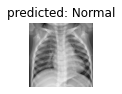

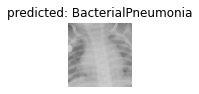

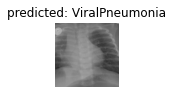

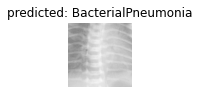

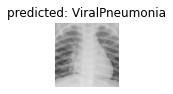

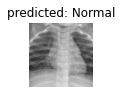

In [0]:
visualize_model(model_resnet18)

### Visualize Resnet50

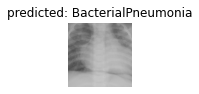

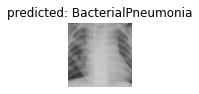

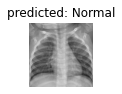

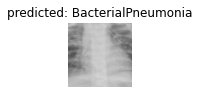

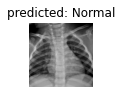

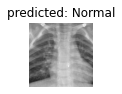

In [0]:
visualize_model(model_resnet50)

### Visualize EfficientNet-b0

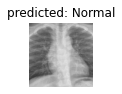

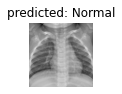

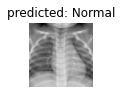

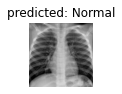

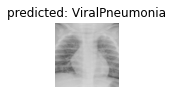

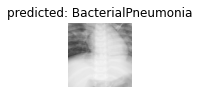

In [0]:
visualize_model(model_efficientnetb0)

### Script to get Predictions

In [0]:
def actual_label(l):
  if l == 0: 
    return 'BacterialPneumonia'
  if l == 1 :
    return 'Covid-19'
  if l == 2 : 
    return 'Normal'
  if l == 3 : 
    return 'ViralPneumonia'

def get_preds(model):
  inputs, labels = iter(dataloaders['ValData']).next()

  inputs = inputs.to(device)
  inp = torchvision.utils.make_grid(inputs)

  outputs = model(inputs)
  _, preds = torch.max(outputs, 1)

  for j in range(len(inputs)):
      print ("Actual label", actual_label(np.array(labels)[j]))

      inp = inputs.data[j]
      imshow(inp, 'predicted:' + class_names[preds[j]])

### Get predictions of Resnet18 on a batch of data

In [0]:
get_preds(model_resnet18)

### Check predictions of Resnet50 on a batch of data

In [0]:
get_preds(model_resnet50)

### Check predictions of EfficientNet-b0 on a batch of data

In [0]:
get_preds(model_efficientnetb0)

### Future works
1.   Add localization
2.   Benchmarking with other metrics (f1, auc)
3.   Try [CovidX dataset](https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md)
4.   Propose lightweight model.



### Conclusion thoughts

1.   Very less covid images, high correraltion between pneumonia images
2.   Model overfits quickly
3.   Dataset cleaning, alignment is required
4.   Model is highly sensitive between pneumonia and covid images
5.   Augmentation does not work well. Creates high senstivity between covid and pneumonia 
